In [21]:
import goes2go
import pandas as pd
import numpy as np
import xarray as xr
from goes2go import GOES
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

import fsspec
fs = fsspec.filesystem('s3', anon=True)
fsspec_caching = {
    "cache_type": "blockcache",  # block cache stores blocks of fixed size and uses eviction using a LRU strategy.
    "block_size": 8
    * 1024
    * 1024,  # size in bytes per block, adjust depends on the file size but the recommended size is in the MB
}

#### Find all files between launch of satellite and now

We need to write a loop around this, since the goes2go searching across long time periods is pretty slow. I also noticed that `goes2go.goes_nearesttime` takes way longer than searching for a timerange.

In [2]:
abi_files = goes2go.goes_timerange(
    start=datetime(2018, 2, 1, 10, 00), 
    end=datetime(2018, 2, 1, 11, 00),
    download=False,
    domain='F',
    product="ABI-L2-CMIP",
    bands=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
)

#### Compile each channel into a separate DataFrame

In [3]:
channel_list = [
    abi_files[abi_files.product_mode == f"ABI-L2-CMIPF-M3C{ch:02d}"].reset_index(drop=True)
    for ch in range(1, 17)
]

#### Find common start times to filter our examples where some channels are missing

In [4]:
# Get the set of 'start' times for each DataFrame
start_sets = [set(df['start']) for df in channel_list]

# Find the intersection of all sets (start times present in all channels)
common_starts = set.intersection(*start_sets)

# Now, filter each DataFrame to only keep rows with these common start times
channel_list_common = [
    df[df['start'].isin(common_starts)].reset_index(drop=True)
    for df in channel_list
]

#### Open example file

Notes on Channel Resolution:

- 0.64 um visible (channel 2) = 0.5 km 
- Other visible/NIR = 1 km
- Bands (>2 um) = 2 km

In [5]:
index = 0
channel = 14
goes_data = xr.open_dataset(fs.open(channel_list_common[channel]['file'][index], **fsspec_caching), engine="h5netcdf")

In [94]:
goes_data

<xarray.Dataset>
Dimensions:                                 (y: 5424, x: 5424,
                                             number_of_time_bounds: 2,
                                             number_of_image_bounds: 2, band: 1)
Coordinates:
    t                                       datetime64[ns] ...
  * y                                       (y) float64 0.1518 ... -0.1518
  * x                                       (x) float64 -0.1518 ... 0.1518
    y_image                                 float32 ...
    x_image                                 float32 ...
    band_wavelength                         (band) float32 ...
    band_id                                 (band) int32 ...
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                band
Data variables: (12/29)
    CMI                                     (y, x) float32 ...
    DQF                                     (y, x) float32 ...
    time_bounds                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  int32 ...
    y_image_bounds                          (number_of_image_bounds) float32 ...
    x_image_bounds                          (number_of_image_bounds) float32 ...
    ...                                      ...
    algorithm_dynamic_input_data_container  int32 ...
    percent_uncorrectable_GRB_errors        float32 ...
    percent_uncorrectable_L0_errors         float32 ...
    earth_sun_distance_anomaly_in_AU        float32 ...
    processing_parm_version_container       int32 ...
    algorithm_product_version_container     int32 ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v25, 05 July 2013)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    cdm_data_type:             Image
    time_coverage_start:       2018-02-01T10:00:45.3Z
    time_coverage_end:         2018-02-01T10:11:22.5Z
    timeline_id:               ABI Mode 3
    production_data_source:    Realtime
    id:                        3e06d055-3c58-4262-b6d4-14975f499003

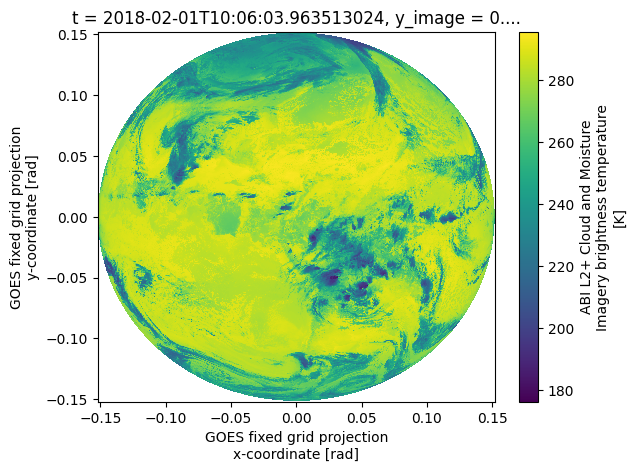

In [84]:
goes_data.CMI.plot()

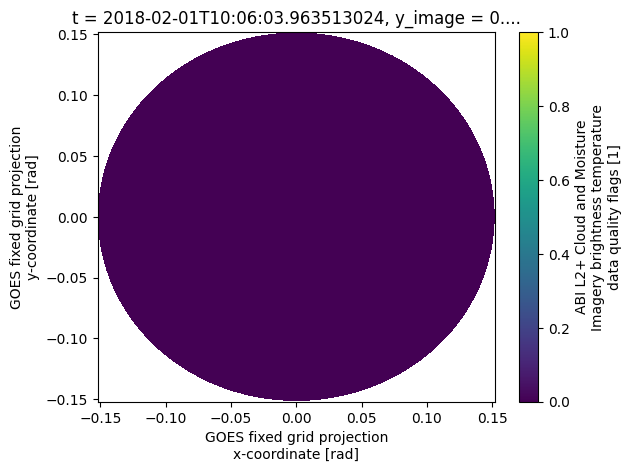

In [9]:
goes_data.DQF.plot()

#### Create sub-patch from full-disk

- Mask percentage of full disk
- Sample with bias towards the center

In [6]:
def create_fov_mask(shape, fov_radius):
    """
    Function to create mask for specified field of view.
    """
    # Create coordinate grids
    y, x = np.ogrid[:shape[0], :shape[1]]
    # Calculate center points
    center_y, center_x = shape[0] // 2, shape[1] // 2
    # Calculate distance from center for each point
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    # Normalize distances by max possible distance (corner to center)
    max_dist = np.sqrt((center_x)**2 + (center_y)**2)
    normalized_dist = dist_from_center / max_dist
    # Create mask for specified field of view
    mask = normalized_dist <= fov_radius
    return mask

##### Steps Explained:

In [18]:
# Some steps explained:
# 1. We first create an x/y meshgrid of the datasets
x_grid, y_grid = np.meshgrid(np.arange(0, goes_data.x.shape[0], 1), np.arange(0, goes_data.y.shape[0], 1))
x_grid, y_grid

(array([[   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423],
        ...,
        [   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423],
        [   0,    1,    2, ..., 5421, 5422, 5423]]),
 array([[   0,    0,    0, ...,    0,    0,    0],
        [   1,    1,    1, ...,    1,    1,    1],
        [   2,    2,    2, ...,    2,    2,    2],
        ...,
        [5421, 5421, 5421, ..., 5421, 5421, 5421],
        [5422, 5422, 5422, ..., 5422, 5422, 5422],
        [5423, 5423, 5423, ..., 5423, 5423, 5423]]))

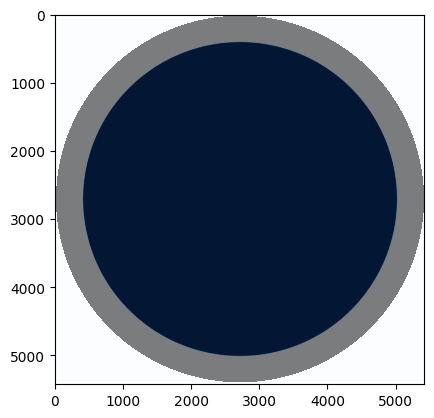

In [ ]:
# 2. We then create mask for valid coordinates within desired field of view
# NOTE: This masks from the center to the image edge, rather than disk edge
valid_mask = create_fov_mask(shape=(goes_data.x.shape[0], goes_data.y.shape[0]), fov_radius=0.6)

plt.imshow(goes_data.DQF.values, cmap='gray')
plt.imshow(valid_mask, alpha=0.5, cmap='Blues')

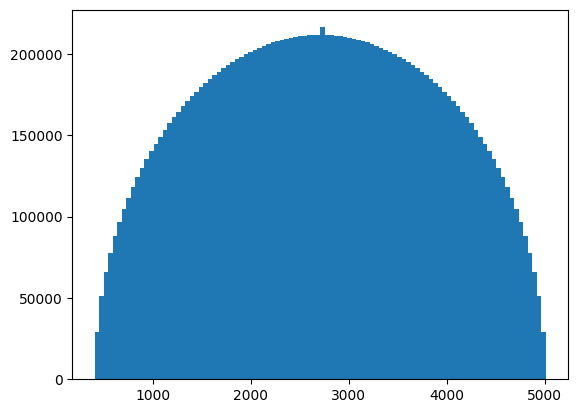

In [39]:
# 3. get coordinate pairs for valid points
coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))
plt.hist(coords_on_disk[:, 0], bins=100);
# This creates a bias of coordates towards the center of the image, that we can sample from

In [ ]:
class CenterWeightedCropDatasetEditor():
    def __init__(self, patch_shape, data_key='Rad', fov_radius=0.6):
        self.patch_shape = patch_shape
        self.data_key = data_key
        self.fov_radius = fov_radius
        self.max_attempts = 5
    def __call__(self, ds):
        assert ds['x'].shape[0] >= self.patch_shape[0], 'Invalid dataset shape: %s' % str(ds['x'].shape)
        assert ds['y'].shape[0] >= self.patch_shape[1], 'Invalid dataset shape: %s' % str(ds['y'].shape)

        # create an x/y meshgrid of the datasets
        x_grid, y_grid = np.meshgrid(np.arange(0, ds.x.shape[0], 1), np.arange(0, ds.y.shape[0], 1))

        # create mask for valid coordinates within desired field of view
        # NOTE: This masks from the center to the image edge, rather than disk edge
        valid_mask = create_fov_mask(shape=(ds.x.shape[0], ds.y.shape[0]), fov_radius=self.fov_radius)

        # get coordinate pairs for valid points
        coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))
        del x_grid, y_grid

        random_idx = np.random.randint(0, len(coords_on_disk))
        x, y = tuple(coords_on_disk[random_idx])
        # define patch boundaries
        xmin = x - self.patch_shape[0] // 2
        ymin = y - self.patch_shape[1] // 2
        xmax = x + self.patch_shape[0] // 2
        ymax = y + self.patch_shape[1] // 2

        # crop patch
        patch_ds = ds.sel({'x': slice(ds['x'][xmin], ds['x'][xmax - 1]),
                            'y': slice(ds['y'][ymin], ds['y'][ymax - 1])})
        
        # TODO: Add check for data quality
        return patch_ds, xmin, ymin

In [ ]:
# create mask for valid coordinates within desired field of view
# NOTE: This masks from the center to the image edge, rather than disk edge
valid_mask = create_fov_mask(shape=(goes.x.shape[0], ds.y.shape[0]), fov_radius=self.fov_radius)

# get coordinate pairs for valid points
coords_on_disk = np.column_stack((x_grid[valid_mask], y_grid[valid_mask]))

In [14]:
patch_size = 1024

crop = CenterWeightedCropDatasetEditor(patch_shape=(patch_size, patch_size), data_key='CMI', fov_radius=0.6)
patch_ds, xmin, ymin = crop(goes_data)

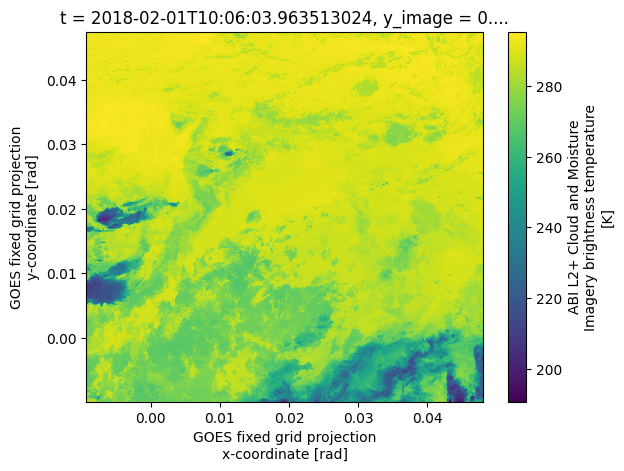

In [16]:
patch_ds.CMI.plot()

Next Steps:

- Rename variables
- Load other channels
- Interpolate / crop them to the same grid


Questions:
- What resolution do we want to pick as an "anchor"?
- Any additional metadata to pass through?